<a href="https://colab.research.google.com/github/Orth33/music-genre-classification/blob/main/Music_Genre_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install librosa matplotlib seaborn scikit-learn tensorflow pandas numpy

## **4. Importing Libraries**

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

## **5. Dataset Loading and Verification**

In [ ]:
# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1


In [ ]:
base_path = "/root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data"
print(os.listdir(base_path))

['genres_original', 'images_original', 'features_3_sec.csv', 'features_30_sec.csv']


# **🔹 PART A: TABULAR FEATURE-BASED CLASSIFICATION**

**6. Loading Audio Features**





In [ ]:
df = pd.read_csv(f"{base_path}/features_3_sec.csv")
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


**7. Data Cleaning and Preprocessing**

In [ ]:
df = df.drop(columns=['filename', 'length'], errors='ignore')

In [ ]:
# Separating Features and Target Variable
X = df.drop('label', axis=1)
y = df['label']

In [ ]:
# Encoding Genre Labels
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**8. Train–Test Split**

In [ ]:
# Splitting the Dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

**9. Model Training (Random Forest)**

In [ ]:
# Choosing the Model
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

rf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=200, random_state=42)

**10. Model Evaluation (Tabular Approach)**

In [ ]:
# Performance Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=encoder.classes_))


Accuracy: 0.8708708708708709
              precision    recall  f1-score   support

       blues       0.87      0.86      0.87       200
   classical       0.90      0.95      0.93       199
     country       0.80      0.83      0.82       199
       disco       0.85      0.84      0.85       200
      hiphop       0.92      0.90      0.91       200
        jazz       0.85      0.90      0.87       200
       metal       0.87      0.97      0.92       200
         pop       0.95      0.81      0.88       200
      reggae       0.82      0.88      0.85       200
        rock       0.89      0.76      0.82       200

    accuracy                           0.87      1998
   macro avg       0.87      0.87      0.87      1998
weighted avg       0.87      0.87      0.87      1998



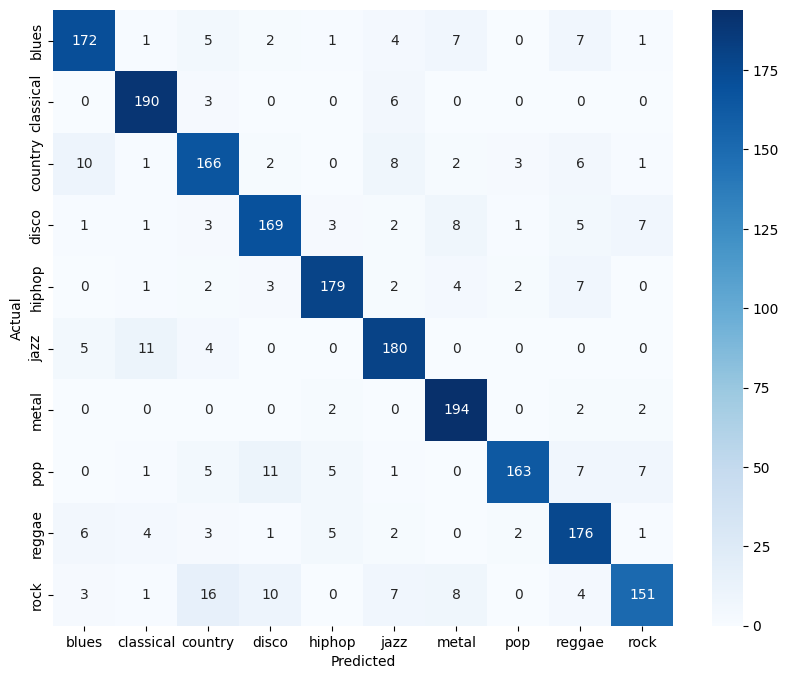

In [ ]:
# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    xticklabels=encoder.classes_,
    yticklabels=encoder.classes_,
    cmap='Blues'
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# **🔹 PART B: IMAGE-BASED CLASSIFICATION (CNN)**

**11. Loading Spectrogram Images**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    f"{base_path}/images_original",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    f"{base_path}/images_original",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 800 images belonging to 10 classes.
Found 199 images belonging to 10 classes.


**12. Transfer Learning Model**

In [ ]:
# Using MobileNetV2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [ ]:
# Model Architecture
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Model Compilation
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

**13. Model Training (CNN)**

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15
)

**14. CNN Evaluation**

In [ ]:
val_loss, val_acc = model.evaluate(val_gen)
print("Validation Accuracy:", val_acc)

**14.1 Training vs Validation Analysis**

The training history reveals a large performance gap between training and validation accuracy. Although the model converges rapidly on the training set, validation performance stagnates, indicating overfitting. This suggests that the model learns dataset-specific patterns rather than genre-invariant acoustic features.

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.show()

# **🔹 PART B.1: TL-IMAGE-BASED CLASSIFICATION (CNN) WITH 10K DATA**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import librosa
from tqdm import tqdm # Useful for seeing progress

In [ ]:
# Create a new directory for the 3sec slices
base_dir = 'gtzan_slices'
os.makedirs(base_dir, exist_ok=True)

genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()

print("Starting slicing process. Corrupted files will be skipped automatically.")

for g in genres:
    os.makedirs(os.path.join(base_dir, g), exist_ok=True)
    # Update this path if your Kaggle path is different
    genre_path = f'/root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/genres_original/{g}'

    # Use tqdm to show a progress bar for each genre
    for filename in tqdm(os.listdir(genre_path), desc=f"Processing {g}"):
        songpath = os.path.join(genre_path, filename)

        try:
            # Load 30s audio
            # We use try/except specifically for jazz.00054.wav
            y_full, sr = librosa.load(songpath, mono=True)

            # Slice into 10 chunks of 3 seconds each
            for i in range(10):
                start = i * 3 * sr
                end = (i + 1) * 3 * sr
                y_chunk = y_full[start:end]

                # Create Mel Spectrogram
                ps = librosa.feature.melspectrogram(y=y_chunk, sr=sr, n_mels=128)
                ps_db = librosa.power_to_db(ps, ref=np.max)

                # Save as image
                save_path = f"{base_dir}/{g}/{filename[:-3].replace('.', '_')}_{i}.png"
                plt.imsave(save_path, ps_db, cmap='magma')

        except Exception as e:
            print(f"\n[SKIP] Could not process {filename}: {e}")
            continue

print("\nSuccess! Your 10,000-image dataset is ready in 'gtzan_slices'.")

Starting slicing process. Corrupted files will be skipped automatically.


Processing jazz:  22%|██▏       | 22/100 [00:04<00:14,  5.45it/s]/tmp/ipython-input-2796739193.py:21: UserWarning: PySoundFile failed. Trying audioread instead.
  y_full, sr = librosa.load(songpath, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processing jazz:  24%|██▍       | 24/100 [00:04<00:14,  5.16it/s]


[SKIP] Could not process jazz.00054.wav: 


Processing rock: 100%|██████████| 100/100 [00:21<00:00,  4.64it/s]


Success! Your 10,000-image dataset is ready in 'gtzan_slices'.


In [ ]:
# Setup Paths with 10k data
IMG_PATH_2 = '/content/gtzan_slices'
BATCH_SIZE = 32
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [ ]:
# Load Data (Split into Train/Validation)
train_ds = tf.keras.utils.image_dataset_from_directory(
    IMG_PATH_2,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    IMG_PATH_2,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

Found 9990 files belonging to 10 classes.
Using 7992 files for training.
Found 9990 files belonging to 10 classes.
Using 1998 files for validation.


In [ ]:
# Optimize performance (caching)
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

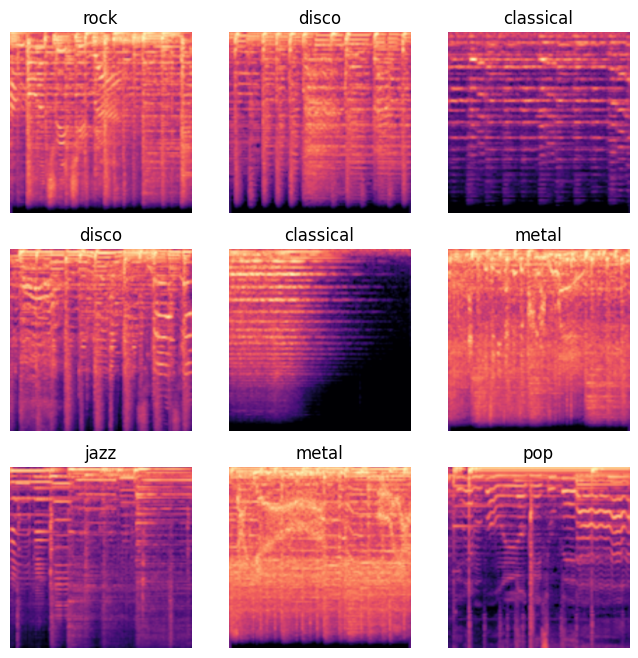

In [ ]:
# Display train dataset
data_path = '/content/gtzan_slices'
class_names = sorted([d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))])

plt.figure(figsize=(8,8))

for images, labels in train_ds.take(1):  # take one batch
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
# Using MobileNetV2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [ ]:
# 1. Use the Pre-trained MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet'
)

# 2. Freeze the base model so we don't destroy its pre-learned features
base_model.trainable = False

# 3. Build the new model
inputs = tf.keras.Input(shape=(256, 256, 3))
# MobileNet expects inputs in range [-1, 1], this helper does it for us
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x) # Turns features into a single vector
x = layers.Dropout(0.3)(x) # Help with overfitting
outputs = layers.Dense(10)(x) # 10 genres

model_tl = tf.keras.Model(inputs, outputs)

model_tl.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# 4. Train (No "Reverse" or "Rotated" music this time!)
history_tl = model_tl.fit(train_ds, validation_data=val_ds, epochs=20)

/tmp/ipython-input-2661947643.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 69s 185ms/step - accuracy: 0.3597 - loss: 1.8605 - val_accuracy: 0.6567 - val_loss: 1.0446
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.6145 - loss: 1.1275 - val_accuracy: 0.6827 - val_loss: 0.9315
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.6779 - loss: 0.9379 - val_accuracy: 0.7192 - val_loss: 0.8380
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.6990 - loss: 0.9000 - val_accuracy: 0.7302 - val_loss: 0.8073
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.7224 - loss: 0.8199 - val_accuracy: 0.7477 - val_loss: 0.7748
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.7387 - loss: 0.7814 - val_accuracy: 0.7583 - val_loss: 0.7474
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.7361 - loss: 0.7637 - val_accuracy: 0.7553 - val_loss: 0.7507
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.7423 - loss: 0.7503 -

In [ ]:
history_tl = model_tl.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.7976 - loss: 0.5998 - val_accuracy: 0.7873 - val_loss: 0.6446
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.7868 - loss: 0.6117 - val_accuracy: 0.7858 - val_loss: 0.6504
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.7846 - loss: 0.6254 - val_accuracy: 0.7828 - val_loss: 0.6551
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.7957 - loss: 0.5970 - val_accuracy: 0.7868 - val_loss: 0.6476
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.7924 - loss: 0.6000 - val_accuracy: 0.7833 - val_loss: 0.6616
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.8028 - loss: 0.5803 - val_accuracy: 0.7793 - val_loss: 0.6575
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.7915 - loss: 0.5849 - val_accuracy: 0.7888 - val_loss: 0.6354
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.8081 - loss: 0.5619 - 

In [ ]:
# 4. Final Validation Accuracy & Confusion Matrix
print("\n--- Evaluating Model ---")
val_loss, val_acc = model_tl.evaluate(val_ds)
print(f"\nFinal Validation Accuracy: {val_acc*100:.2f}%")


--- Evaluating Model ---
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.7870 - loss: 0.6483

Final Validation Accuracy: 79.13%


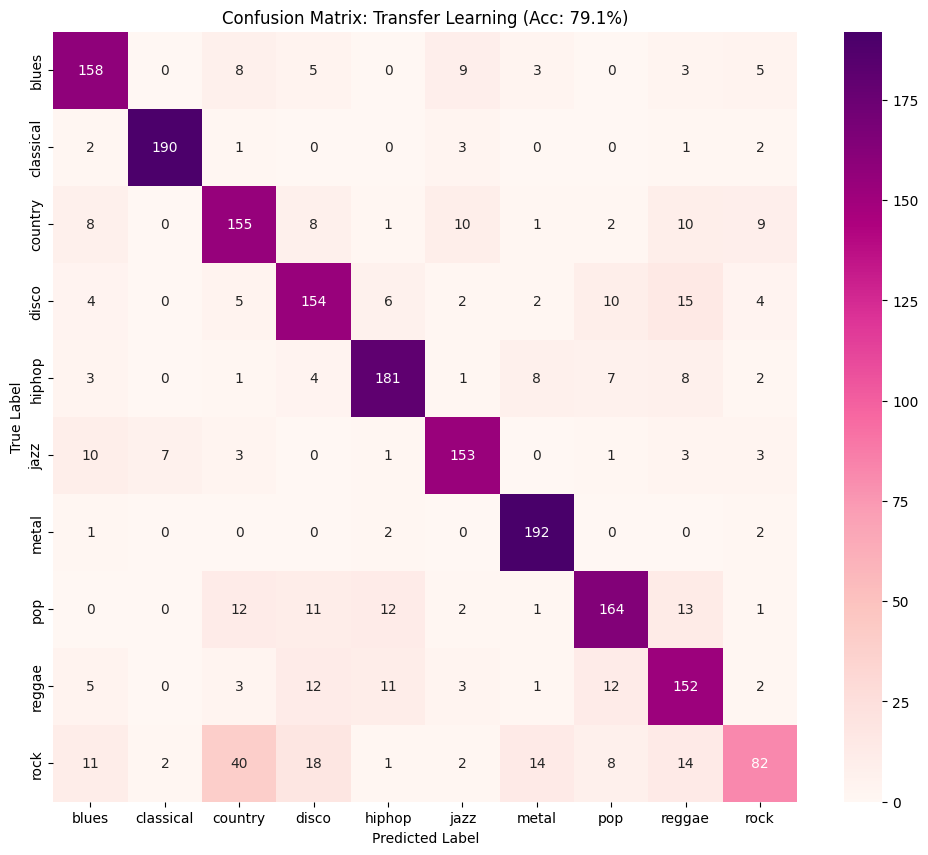


Classification Report:
              precision    recall  f1-score   support

       blues       0.78      0.83      0.80       191
   classical       0.95      0.95      0.95       199
     country       0.68      0.76      0.72       204
       disco       0.73      0.76      0.74       202
      hiphop       0.84      0.84      0.84       215
        jazz       0.83      0.85      0.84       181
       metal       0.86      0.97      0.92       197
         pop       0.80      0.76      0.78       216
      reggae       0.69      0.76      0.72       201
        rock       0.73      0.43      0.54       192

    accuracy                           0.79      1998
   macro avg       0.79      0.79      0.79      1998
weighted avg       0.79      0.79      0.79      1998



In [ ]:
# Confusion Matrix Visualization
from sklearn.metrics import confusion_matrix, classification_report
# Collect all true labels and predictions
y_true = []
y_pred_probs = []

for images, labels in val_ds:
    y_true.extend(labels.numpy())
    preds = model_tl.predict(images, verbose=0)
    y_pred_probs.extend(preds)

y_pred = np.argmax(y_pred_probs, axis=1)

# 5. Plotting
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdPu',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix: Transfer Learning (Acc: {val_acc*100:.1f}%)')
plt.show()

# Print detailed report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))